In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harinirajm0han","key":"100c1efc22c35b615f535c36d208cc3e"}'}

In [ ]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d skooch/ddsm-mammography

Dataset URL: https://www.kaggle.com/datasets/skooch/ddsm-mammography
License(s): CC0-1.0
 99% 2.85G/2.88G [00:46<00:00, 83.2MB/s]
100% 2.88G/2.88G [00:46<00:00, 66.3MB/s]


In [ ]:
!unzip ddsm-mammography.zip -d /content/ddsm_dataset

Archive:  ddsm-mammography.zip
  inflating: /content/ddsm_dataset/cv10_data/cv10_data.npy  
  inflating: /content/ddsm_dataset/cv10_labels.npy  
  inflating: /content/ddsm_dataset/test10_data/test10_data.npy  
  inflating: /content/ddsm_dataset/test10_labels.npy  
  inflating: /content/ddsm_dataset/training10_0/training10_0.tfrecords  
  inflating: /content/ddsm_dataset/training10_1/training10_1.tfrecords  
  inflating: /content/ddsm_dataset/training10_2/training10_2.tfrecords  
  inflating: /content/ddsm_dataset/training10_3/training10_3.tfrecords  
  inflating: /content/ddsm_dataset/training10_4/training10_4.tfrecords  


In [ ]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import tensorflow as tf
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

No of images: 11177


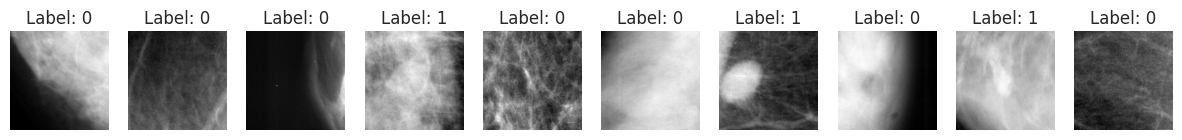

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt


def parse_tfrecord_fn(serialized_example):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    features = tf.io.parse_single_example(serialized_example, feature_description)

    label = features['label_normal']
    image = tf.io.decode_raw(features['image'], tf.uint8)

    image = tf.reshape(image, [299, 299, 1])

    return label, image



tfrecord_path = '/content/ddsm_dataset/training10_0/training10_0.tfrecords'


dataset = tf.data.TFRecordDataset(tfrecord_path)


parsed_dataset = dataset.map(parse_tfrecord_fn)


num_images = sum(1 for _ in parsed_dataset)
print("No of images:", num_images)


num_examples_to_display = 10
fig, axes = plt.subplots(1, num_examples_to_display, figsize=(15, 3))

for i, (label, image) in enumerate(parsed_dataset.take(num_examples_to_display)):
    axes[i].imshow(image.numpy().reshape(299, 299), cmap='gray')
    axes[i].set_title(f"Label: {label.numpy()}")
    axes[i].axis('off')

plt.show()


No of images: 11177


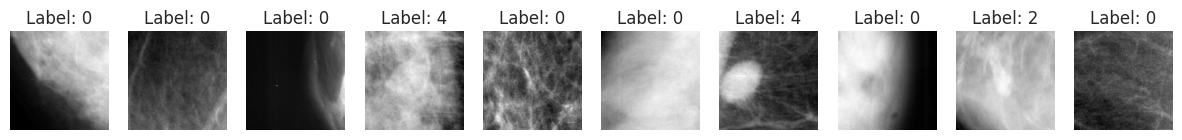

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt


def parse_tfrecord_fn(serialized_example):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    features = tf.io.parse_single_example(serialized_example, feature_description)


    label = features['label']
    image = tf.io.decode_raw(features['image'], tf.uint8)


    image = tf.reshape(image, [299, 299, 1])

    return label, image


tfrecord_path = '/content/ddsm_dataset/training10_0/training10_0.tfrecords'


dataset = tf.data.TFRecordDataset(tfrecord_path)


parsed_dataset = dataset.map(parse_tfrecord_fn)


num_images = 0


for _ in parsed_dataset:
    num_images += 1


print("No of images:", num_images)


num_examples_to_display = 10



fig, axes = plt.subplots(1, num_examples_to_display, figsize=(15, 3))


for i, (label, image) in enumerate(parsed_dataset.take(num_examples_to_display)):

    axes[i].imshow(image.numpy().reshape(299, 299), cmap='gray')
    axes[i].set_title(f"Label: {label.numpy()}")
    axes[i].axis('off')


plt.show()

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
import os

filenames = []
base_path = "/content/ddsm_dataset"


for folder in ["training10_0", "training10_1", "training10_2", "training10_3", "training10_4"]:
    folder_path = os.path.join(base_path, folder)


    if os.path.isdir(folder_path):

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            filenames.append(file_path)


for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))


Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None

In [ ]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True,stratify=y)

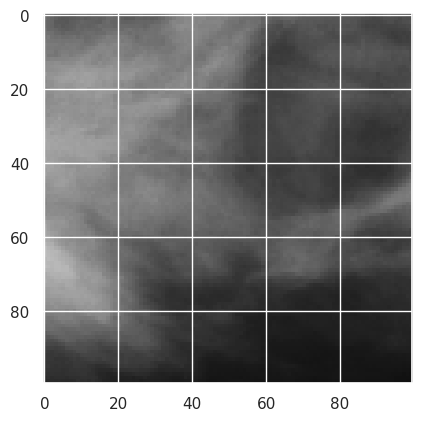

In [ ]:
plt.imshow(x_train[0])

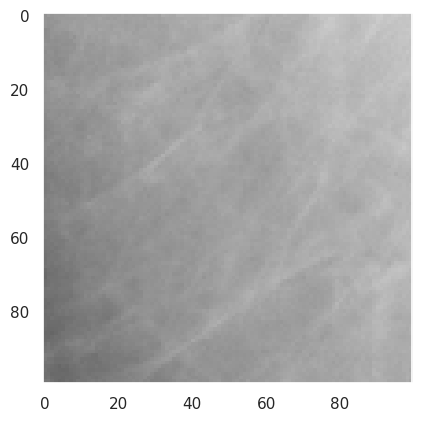

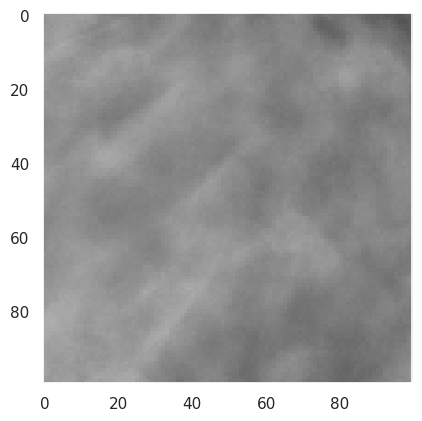

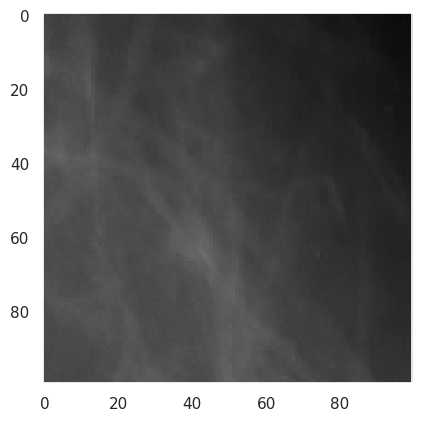

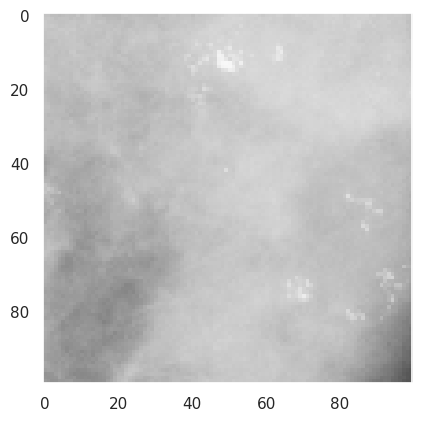

In [ ]:
for i in x_train[:4]:
    plt.imshow(i.squeeze(), cmap='gray')
    plt.grid(False)
    plt.show()


Text(0.5, 1.0, 'Distribution of label in the Dataset')

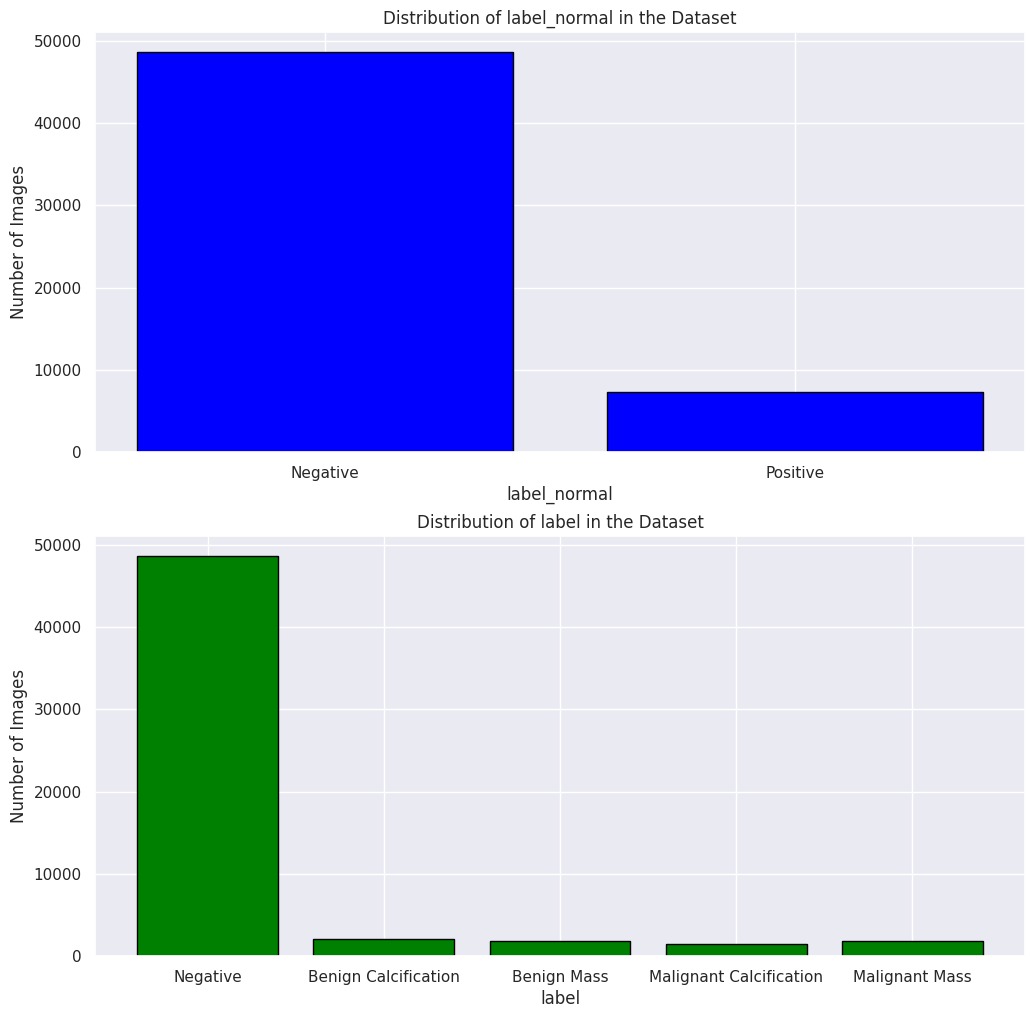

In [ ]:

def tfr_parse(example):
    example = tf.io.parse_single_example(example, feature_dictionary)
    label = example['label']
    label_normal = example['label_normal']
    return label, label_normal



raw_dataset = tf.data.TFRecordDataset(filenames)
dataset = raw_dataset.map(tfr_parse)


labels, labels_normal = zip(*[(label.numpy(), label_normal.numpy()) for label, label_normal in dataset])


fig, axes = plt.subplots(2, 1, figsize=(12, 12))


axes[0].hist(labels_normal, bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.8, color='blue', edgecolor='black')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negative', 'Positive'])
axes[0].set_xlabel('label_normal')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Distribution of label_normal in the Dataset')


axes[1].hist(labels, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], align='mid', rwidth=0.8, color='green', edgecolor='black')
axes[1].set_xticks([0, 1, 2, 3, 4])
axes[1].set_xticklabels(['Negative', 'Benign Calcification', 'Benign Mass', 'Malignant Calcification', 'Malignant Mass'])
axes[1].set_xlabel('label')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Distribution of label in the Dataset')

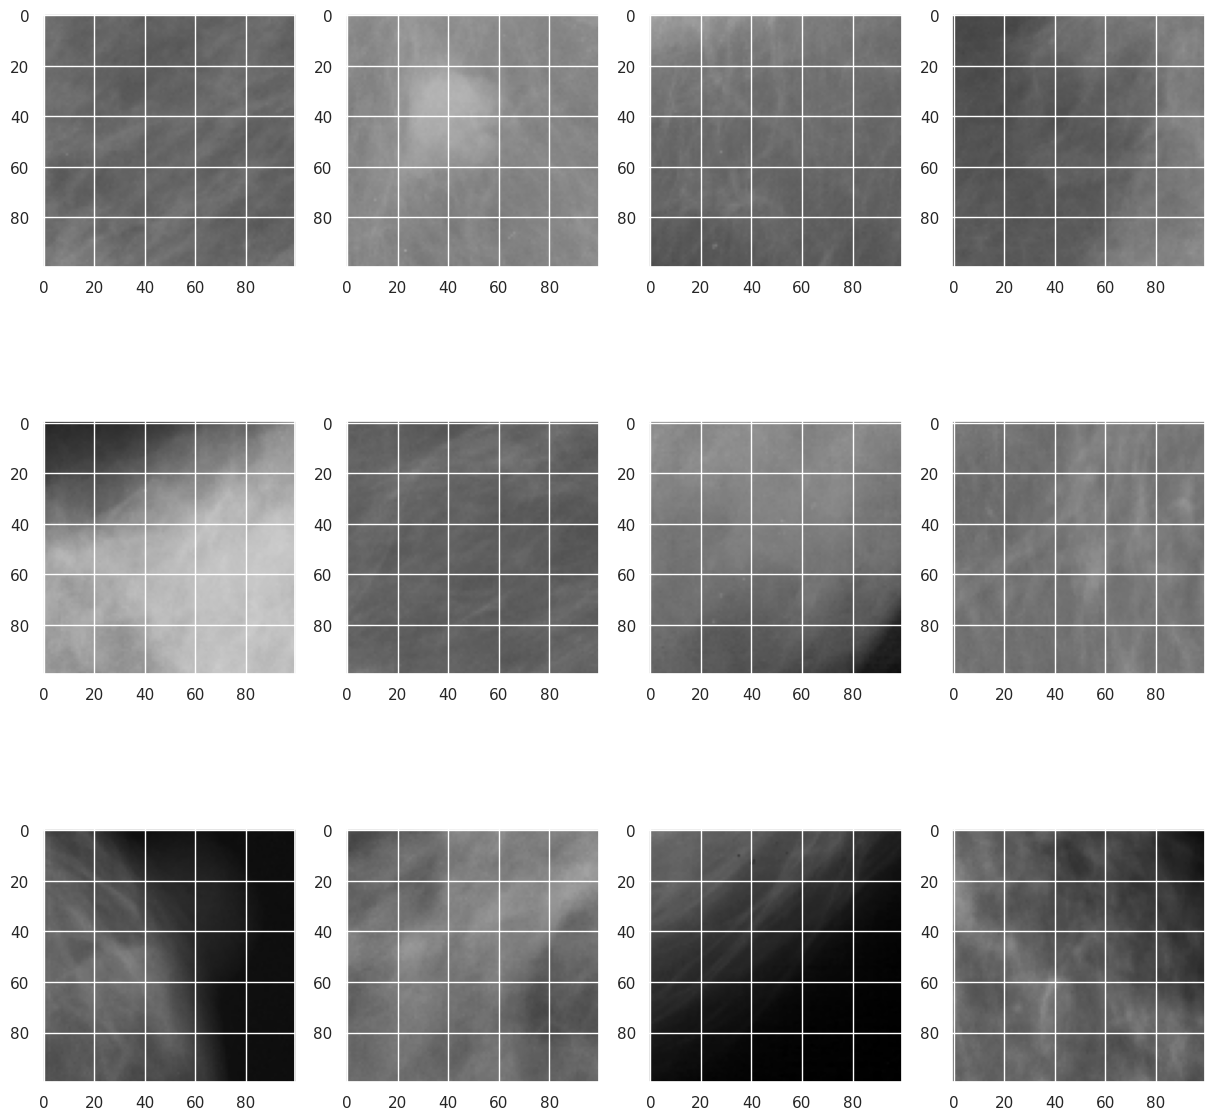

In [ ]:
fig=plt.figure(figsize=(15,15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[i])
plt.show()

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 3)


In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Define AlexNet model
def create_alexnet():
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation='relu'))

    # Fourth Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation='relu'))

    # Fifth Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))  # Binary Classification

    return model

# Create the model
alexnet_sgd = create_alexnet()

# Compile with SGD optimizer
alexnet_sgd.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
alexnet_sgd.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 23, 23, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 5, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,731,009 (94.34 MB)

 Trainable params: 24,731,009 (94.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = alexnet_sgd.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.8602 - loss: 0.5510 - val_accuracy: 0.8750 - val_loss: 0.3665
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.8857 - loss: 0.3542 - val_accuracy: 0.8885 - val_loss: 0.3320
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8868 - loss: 0.3325 - val_accuracy: 0.8954 - val_loss: 0.3117
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8874 - loss: 0.3316 - val_accuracy: 0.9000 - val_loss: 0.2992
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8971 - loss: 0.2983 - val_accuracy: 0.8909 - val_loss: 0.2890
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8978 - loss: 0.2880 - val_accuracy: 0.9052 - val_loss: 0.2651
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9005 - loss: 0.2692 - val_accuracy: 0.9000 - val_loss: 0.2709
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8979 - loss: 0.2672 - 

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = alexnet_sgd.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9085 - loss: 0.2344
Test Loss: 0.2326
Test Accuracy: 0.9092


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
AUC-ROC: 0.9274


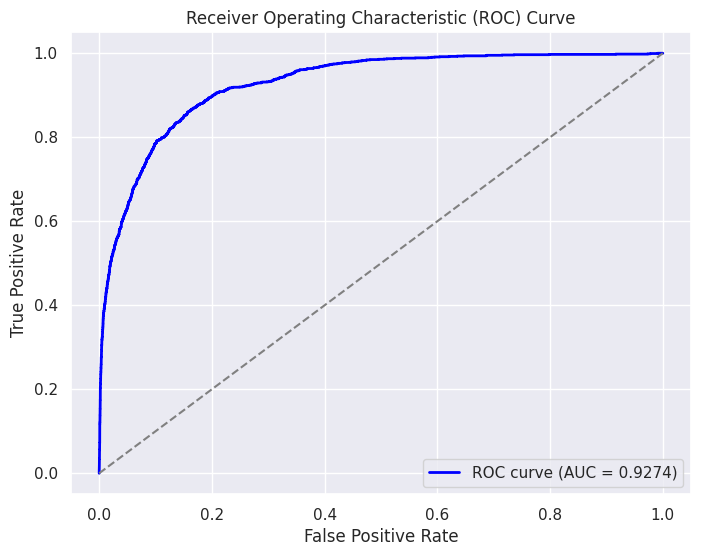

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

# Assume you have test data (X_test, y_test)
# Make predictions (probabilities)
y_pred_prob = alexnet_sgd.predict(x_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate Precision, Recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Print scores

print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


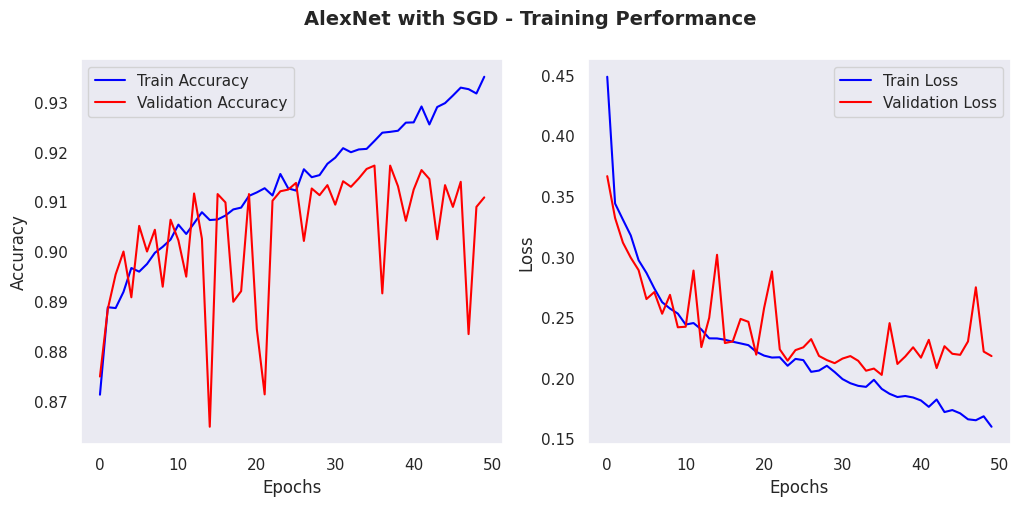

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Single title for both subplots
plt.suptitle("AlexNet with SGD - Training Performance", fontsize=14, fontweight='bold')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.show()


In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the model
alexnet_adam = create_alexnet()

# Compile with Adam optimizer
alexnet_adam.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Print model summary
alexnet_adam.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 23, 23, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 11, 11, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 5, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 5, 5, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,731,009 (94.34 MB)

 Trainable params: 24,731,009 (94.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = alexnet_adam.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 0.8514 - loss: 4.8068 - val_accuracy: 0.8917 - val_loss: 0.2625
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8914 - loss: 0.2675 - val_accuracy: 0.8931 - val_loss: 0.2726
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8934 - loss: 0.2616 - val_accuracy: 0.8416 - val_loss: 0.3248
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8706 - loss: 0.3863 - val_accuracy: 0.8675 - val_loss: 0.3258
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8855 - loss: 0.2735 - val_accuracy: 0.8943 - val_loss: 0.2528
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8927 - loss: 0.2716 - val_accuracy: 0.8967 - val_loss: 0.2620
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9016 - loss: 0.2421 - val_accuracy: 0.8958 - val_loss: 0.2495
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9035 - loss: 0.2377 - 

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = alexnet_adam.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8732 - loss: 0.3809
Test Loss: 0.3875
Test Accuracy: 0.8696


In [ ]:
# Evaluate the model on test data
test_loss, test_acc = alexnet_adam.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8732 - loss: 0.3804
Test Loss: 0.3872
Test Accuracy: 0.8696


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
AUC Score: 0.4999


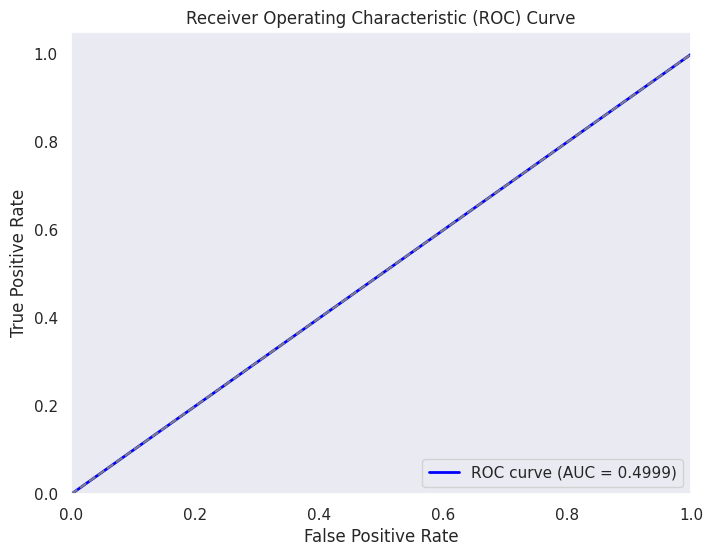

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Assuming you have test data (x_test, y_test)
y_pred_prob = alexnet_adam.predict(x_test)  # Get predicted probabilities

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())  # Flatten arrays if needed
roc_auc = auc(fpr, tpr)

# Print AUC value
print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


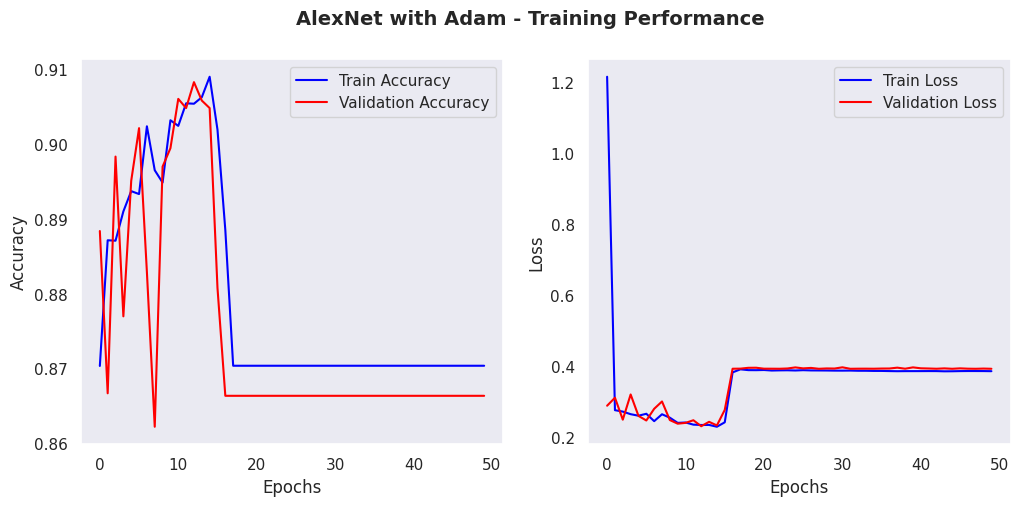

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Single title for both subplots
plt.suptitle("AlexNet with Adam - Training Performance", fontsize=14, fontweight='bold')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.show()


In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Create the model
alexnet_rmsprop = create_alexnet()

# Compile with RMSprop optimizer
alexnet_rmsprop.compile(optimizer=RMSprop(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Print model summary
alexnet_rmsprop.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 23, 23, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 11, 11, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 11, 11, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 5, 5, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 5, 5, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,731,009 (94.34 MB)

 Trainable params: 24,731,009 (94.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = alexnet_rmsprop.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8691 - loss: 0.5090 - val_accuracy: 0.8664 - val_loss: 9.2355
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8645 - loss: 0.6514 - val_accuracy: 0.8664 - val_loss: 0.5604
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8730 - loss: 0.4726 - val_accuracy: 0.8664 - val_loss: 0.3822
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8727 - loss: 0.4049 - val_accuracy: 0.8664 - val_loss: 0.3310
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8712 - loss: 0.4015 - val_accuracy: 0.8665 - val_loss: 0.4177
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.8746 - loss: 0.3327 - val_accuracy: 0.8886 - val_loss: 0.3214
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8866 - loss: 0.3112 - val_accuracy: 0.8888 - val_loss: 0.3014
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8867 - loss: 0.2908 - 

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = alexnet_rmsprop.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8950 - loss: 0.2801
Test Loss: 0.3028
Test Accuracy: 0.8898


350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


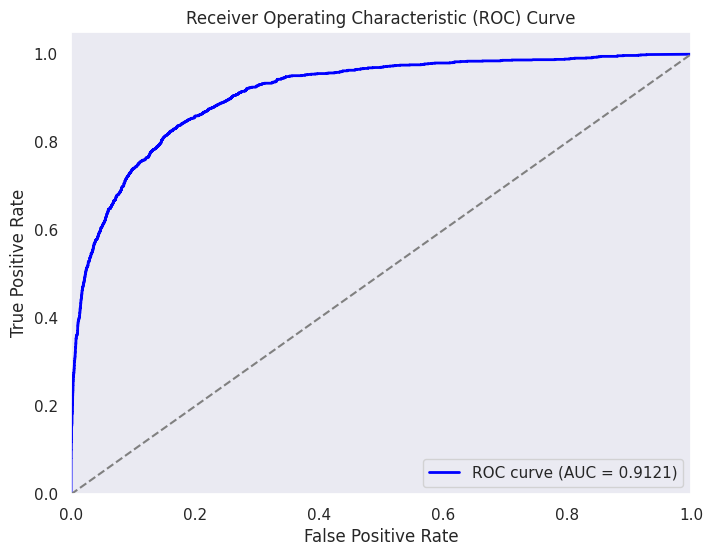

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Assuming you have test data
y_pred_prob = alexnet_rmsprop.predict(x_test)  # Get predicted probabilities
# y_pred_class = np.argmax(y_pred_prob, axis=1)  # Get predicted class labels (for multi-class) - Not needed for binary classification
# y_test_class = np.argmax(y_test, axis=1)  # Get true class labels (for multi-class) - Not needed for binary classification

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())  # Use .ravel() for multi-class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

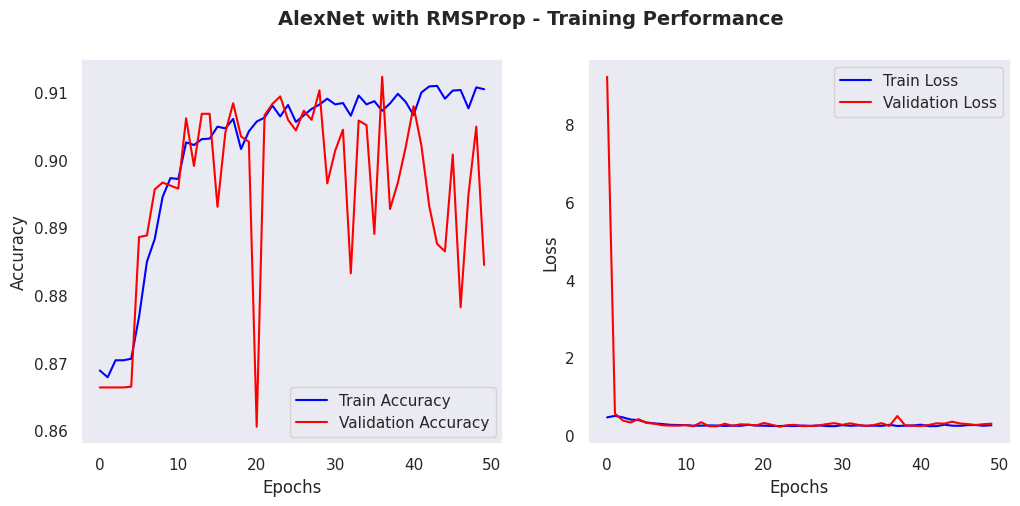

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Single title for both subplots
plt.suptitle("AlexNet with RMSProp - Training Performance", fontsize=14, fontweight='bold')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.show()


In [ ]:

x_train, x_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42,
                                                      shuffle=True,stratify=y)

x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42,
                                                shuffle=True,stratify=y_test1)


In [ ]:
#Defining our ANN Model
ann_model=Sequential()
ann_model.add(Dense(8, input_dim=128, kernel_initializer = 'uniform', activation = 'relu'))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(16, kernel_initializer = 'HeUniform', activation = 'relu'))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(64, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(16, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(1,activation='sigmoid'))
ann_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 8)                   │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,457 (25.22 KB)

 Trainable params: 6,457 (25.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
names = [

        'SVM',

         ]
classifiers = [

    SVC(),



        ]
zipped_clf = zip(names,classifiers)



In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)

    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)

    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)


    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)


    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),2)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),2)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),2)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),2)



    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("Accuracy core : {}%".format(train_accuracy))
    cm=confusion_matrix(y_train,y_pred_train)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(val_accuracy))
    cm=confusion_matrix(y_val,y_pred_val)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

    print('------------------------ Test Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Kappa Score : {} ".format(test_kappa))
    print("Recall score: {}".format(test_recall))
    print("Precision score : {}".format(test_precision))
    cm=confusion_matrix(y_test,y_pred_test)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])


    print("-"*80)
    print()

In [ ]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('Classifier', c)])
        print("------------------------------Fitting {} on input_data-------------------------------- ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [ ]:
base_model= alexnet_sgd(input_shape=(100,100,3), weights='imagenet', include_top=False)
x = base_model.output
# x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
# x = Dense(16,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(128, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
val_features=model_feat.predict(x_val)
test_features=model_feat.predict(x_test)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 73s 54ms/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step


In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

------------------------------Fitting SVM on input_data-------------------------------- 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



------------------------ Train Set Metrics------------------------

Accuracy core : 86.96000000000001%
Confusion matrix, without normalization
[[34017     0]
 [ 5100     2]]


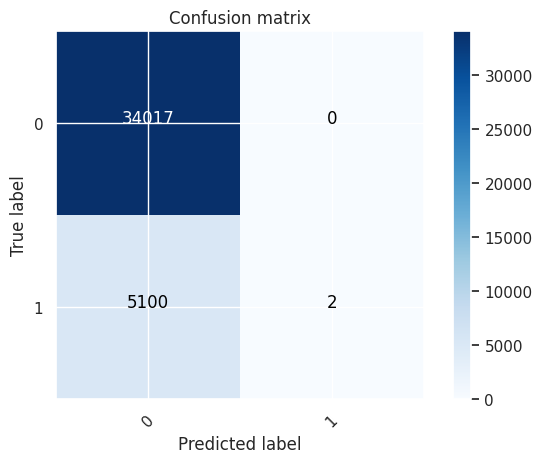

------------------------ Validation Set Metrics------------------------

Accuracy score : 86.95%
Confusion matrix, without normalization
[[10204     1]
 [ 1530     1]]


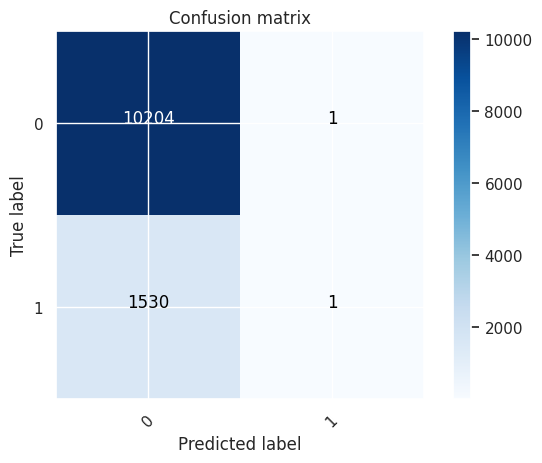

------------------------ Test Set Metrics------------------------

Accuracy score : 86.96000000000001%
F1_score : 0.81
Kappa Score : 0.0 
Recall score: 0.87
Precision score : 0.76
Confusion matrix, without normalization
[[4374    0]
 [ 656    0]]


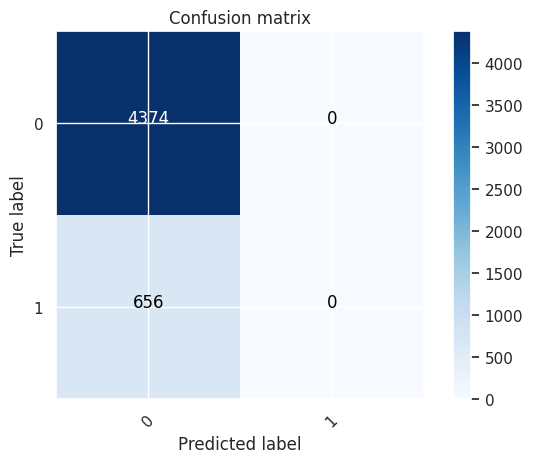

--------------------------------------------------------------------------------



In [ ]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

print(x_train[0].shape)

# Use correct weights or initialize randomly
base_model = DenseNet121(input_shape=(100,100,3), weights=None, include_top=False)



model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()


(100, 100, 3)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 3, 3, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 9216)                │          36,864 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1024)                │              

 Total params: 19,678,785 (75.07 MB)

 Trainable params: 12,614,657 (48.12 MB)

 Non-trainable params: 7,064,128 (26.95 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

In [ ]:
from tensorflow.keras.optimizers import SGD

# Define SGD with learning rate and momentum
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)


model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    shuffle=True,
    epochs=50,
    batch_size=128
)


Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 113s 263ms/step - accuracy: 0.8789 - loss: 0.3021 - val_accuracy: 0.8806 - val_loss: 0.2611
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.8939 - loss: 0.2485 - val_accuracy: 0.9024 - val_loss: 0.2408
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9052 - loss: 0.2303 - val_accuracy: 0.9033 - val_loss: 0.2374
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.9041 - loss: 0.2284 - val_accuracy: 0.9043 - val_loss: 0.2349
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.9036 - loss: 0.2226 - val_accuracy: 0.9034 - val_loss: 0.2342
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.9047 - loss: 0.2229 - val_accuracy: 0.8962 - val_loss: 0.2333
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.9023 - loss: 0.2211 - val_accuracy: 0.9026 - val_loss: 0.2321
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.9053 - loss: 0.2171 

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

350/350 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.9155 - loss: 0.2075
Test_loss_value = 0.20492883026599884
test_accuracy = 0.9152724146842957


350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step


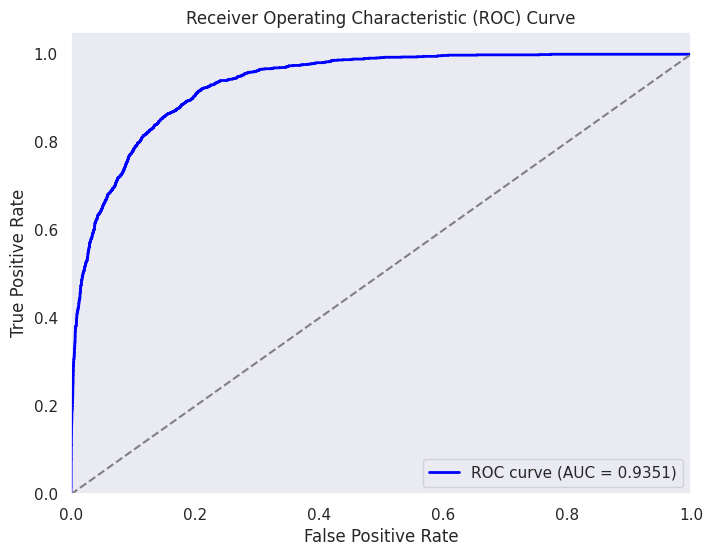

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Assuming you have test data
y_pred_prob = model.predict(x_test)  # Get predicted probabilities
# y_pred_class = np.argmax(y_pred_prob, axis=1)  # Get predicted class labels (for multi-class) - Not needed for binary classification
# y_test_class = np.argmax(y_test, axis=1)  # Get true class labels (for multi-class) - Not needed for binary classification

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())  # Use .ravel() for multi-class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

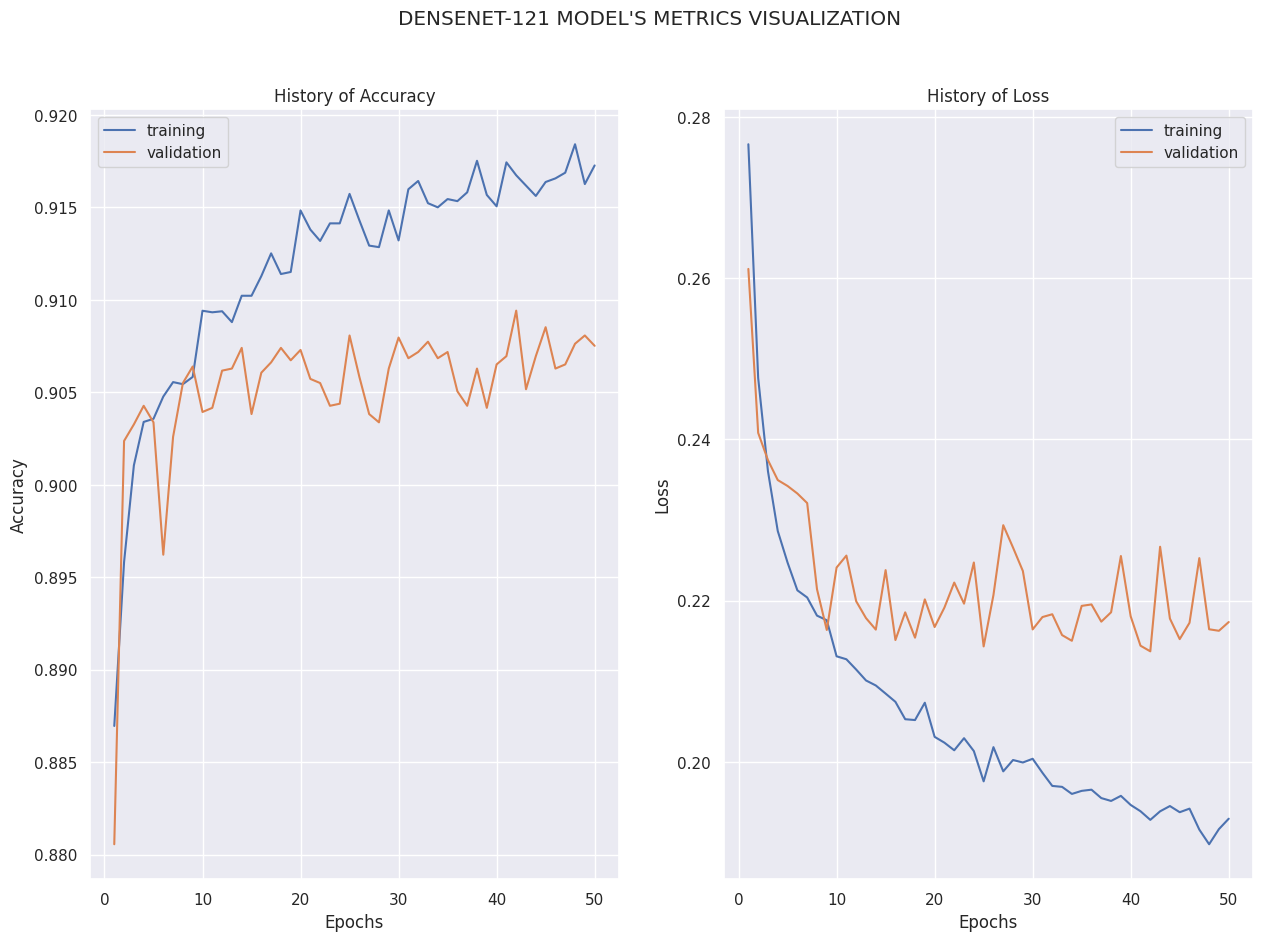

In [ ]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("DENSENET-121 MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define ResNet50 base model
base_model = ResNet50(input_shape=(100, 100, 3), weights=None, include_top=False)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define custom model
model = Sequential([
    base_model,
    Dropout(0.2),
    Flatten(),
    BatchNormalization(),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │      33,555,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 1024)                │              

 Total params: 60,440,449 (230.56 MB)

 Trainable params: 36,779,009 (140.30 MB)

 Non-trainable params: 23,661,440 (90.26 MB)

In [ ]:
# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 20 epochs without callbacks
history = model.fit(
    x_train, y_train,
    validation_split=0.2,  # 20% of data for validation
    shuffle=True,          # Shuffle data during training
    epochs=50,             # Set the number of epochs
    batch_size=128,        # Set batch size
    verbose=1              # Display training progress
)




Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 74s 242ms/step - accuracy: 0.8300 - loss: 0.3942 - val_accuracy: 0.8595 - val_loss: 0.3018
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 45s 122ms/step - accuracy: 0.8965 - loss: 0.2562 - val_accuracy: 0.9024 - val_loss: 0.2358
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 28s 127ms/step - accuracy: 0.8938 - loss: 0.2542 - val_accuracy: 0.8833 - val_loss: 0.2712
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9028 - loss: 0.2342 - val_accuracy: 0.9083 - val_loss: 0.2190
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.9018 - loss: 0.2317 - val_accuracy: 0.9094 - val_loss: 0.2160
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.9072 - loss: 0.2226 - val_accuracy: 0.9029 - val_loss: 0.2196
Epoch 7/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - accuracy: 0.9055 - loss: 0.2167 - val_accuracy: 0.9121 - val_loss: 0.2105
Epoch 8/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - accuracy: 0.9130 - loss: 0

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))


350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9273 - loss: 0.2012
Test_loss_value = 0.21470463275909424
test_accuracy = 0.9207300543785095


350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step
AUC Score: 0.9372


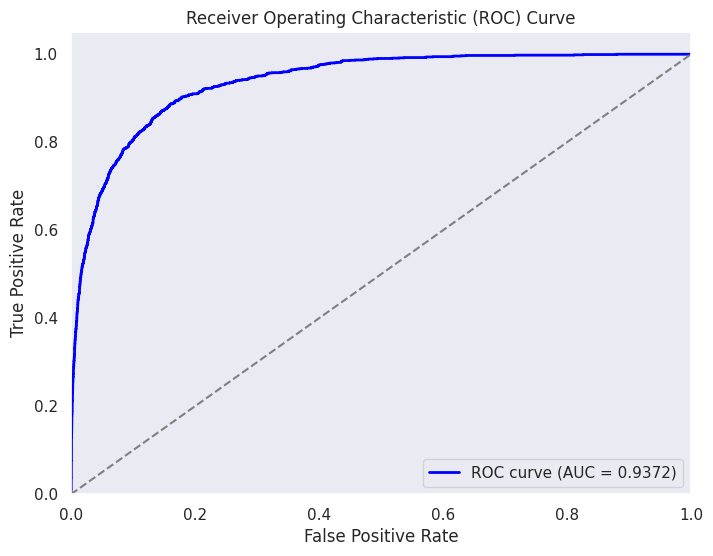

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Assuming you have test data
y_pred_prob = model.predict(x_test)  # Get predicted probabilities

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())  # Use .ravel() to flatten arrays
roc_auc = auc(fpr, tpr)

# Print AUC score
print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


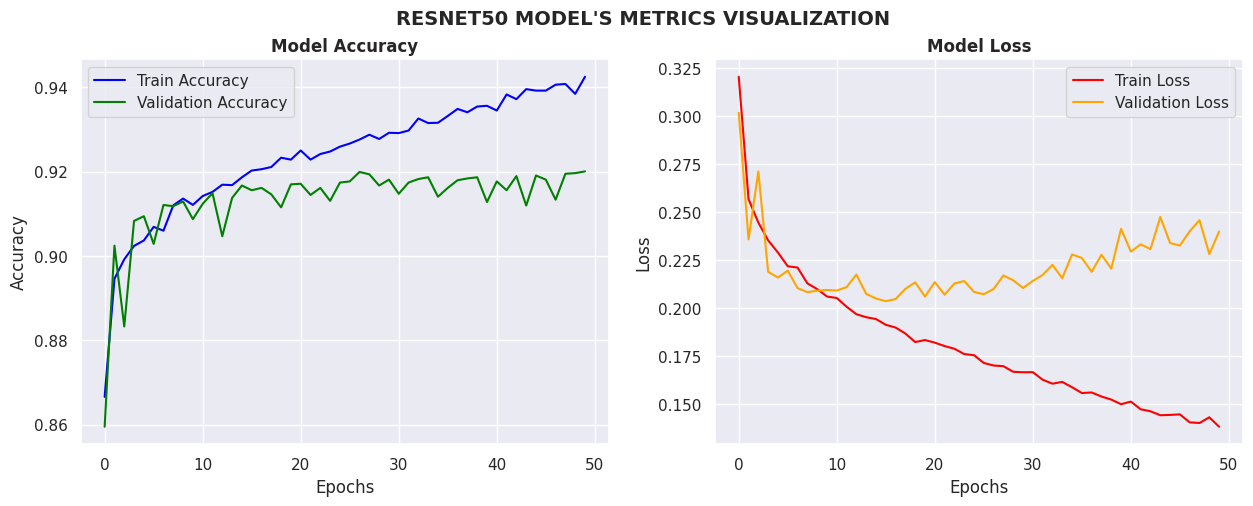

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjusted size for better layout
fig.suptitle("RESNET50 MODEL'S METRICS VISUALIZATION", fontsize=14, fontweight='bold')

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
ax1.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', color='red')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Model Loss', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the plot
plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
# Check input shape (adjust based on your dataset)
print(x_train[0].shape)

# Load the EfficientNetB0 model with pre-trained ImageNet weights
base_model = EfficientNetB0(input_shape=(100, 100, 3), weights='imagenet', include_top=False)

# Freeze base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Build Model
model = Sequential([
    base_model,
    Dropout(0.2),
    Flatten(),
    BatchNormalization(),

    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Print Model Summary
model.summary()


(100, 100, 3)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20480)          │        81,920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    20,972,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,216,548 (103.82 MB)

 Trainable params: 23,119,873 (88.20 MB)

 Non-trainable params: 4,096,675 (15.63 MB)

In [ ]:
from tensorflow.keras.optimizers import SGD


model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),  # You can adjust learning_rate as needed
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.8832 - loss: 0.3024 - val_accuracy: 0.9127 - val_loss: 0.2156
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 881s 3s/step - accuracy: 0.9222 - loss: 0.1927 - val_accuracy: 0.9241 - val_loss: 0.1922
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 907s 3s/step - accuracy: 0.9279 - loss: 0.1741 - val_accuracy: 0.9236 - val_loss: 0.1891
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9390 - loss: 0.1560

In [ ]:


# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 71s 146ms/step - accuracy: 0.8821 - loss: 0.2956 - val_accuracy: 0.9105 - val_loss: 0.2192
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.9181 - loss: 0.2031 - val_accuracy: 0.9219 - val_loss: 0.1911
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.9248 - loss: 0.1853 - val_accuracy: 0.9172 - val_loss: 0.1956
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9299 - loss: 0.1749 - val_accuracy: 0.9198 - val_loss: 0.1893
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9373 - loss: 0.1573 - val_accuracy: 0.9274 - val_loss: 0.1801
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9413 - loss: 0.1502 - val_accuracy: 0.9264 - val_loss: 0.1845
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9423 - loss: 0.1473 - val_accuracy: 0.9272 - val_loss: 0.1851
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9470 - loss: 0.1329 -

In [ ]:
model.save("efficientnetb0_brain_tumor_model.h5")

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9323 - loss: 0.2742
Test_loss_value = 0.27323463559150696
test_accuracy = 0.9330768585205078


350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step
AUC Score: 0.9496


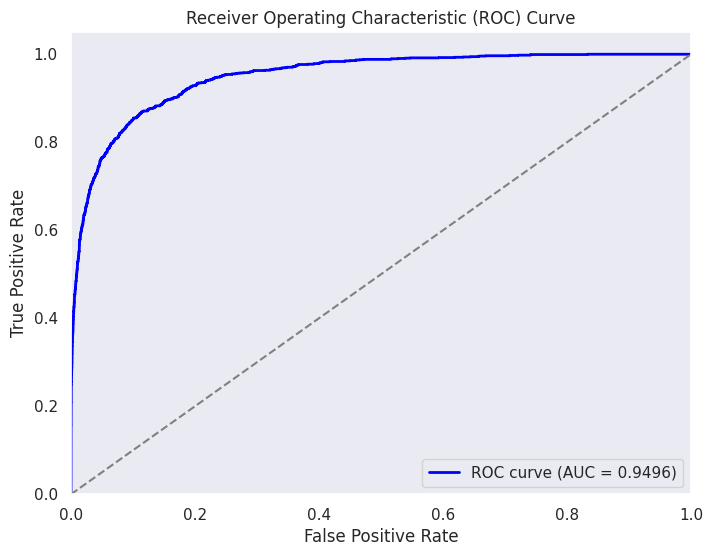

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Assuming you have test data
y_pred_prob = model.predict(x_test)  # Get predicted probabilities

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())  # Use .ravel() to flatten arrays
roc_auc = auc(fpr, tpr)

# Print AUC score
print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


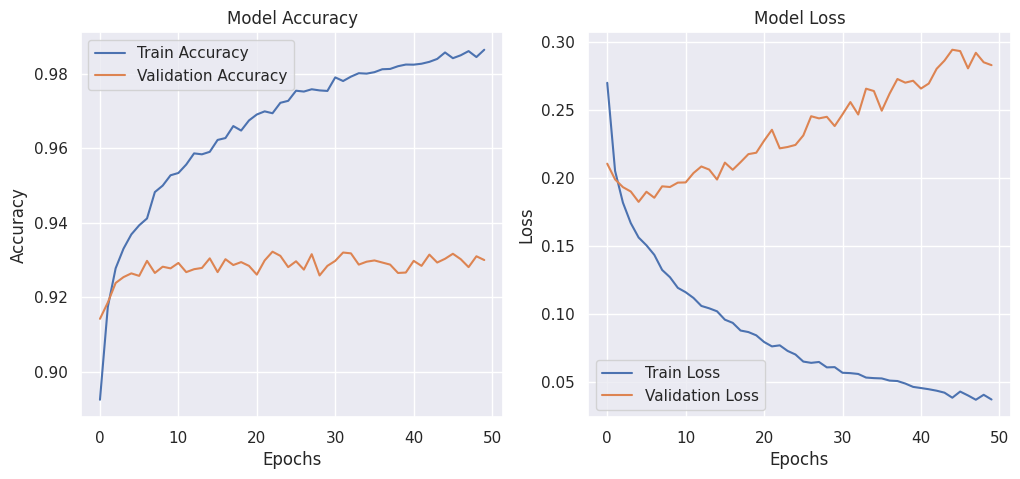

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


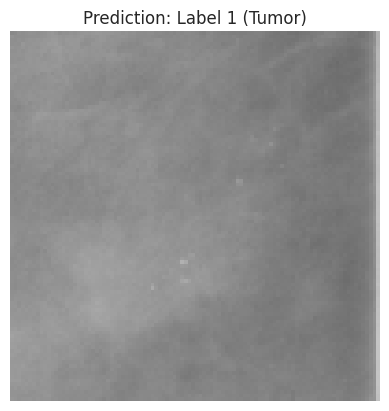

'Label 1 (Tumor)'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to parse TFRecord dataset
def parse_tfrecord_fn(serialized_example):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    features = tf.io.parse_single_example(serialized_example, feature_description)

    label = features['label_normal']
    image = tf.io.decode_raw(features['image'], tf.uint8)

    image = tf.reshape(image, [299, 299, 1])
    image = tf.image.resize(image, [100, 100])
    image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0

    return image, label


tfrecord_path = '/content/ddsm_dataset/training10_4/training10_4.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)


parsed_dataset = (dataset
    .map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)


def classify_tumor_image(model, dataset):
    for image, label in dataset:
        if label.numpy()[0] == 1:
            image_array = image.numpy()


            prediction = model.predict(image_array)
            predicted_label = "Label 1 (Tumor)"


            plt.imshow(image.numpy().squeeze(), cmap='gray')
            plt.title(f"Prediction: {predicted_label}")
            plt.axis("off")
            plt.show()

            return predicted_label

    return "No tumor image found in dataset"


classify_tumor_image(model, parsed_dataset)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Path to the TFRecord file
tfrecord_path = '/content/ddsm_dataset/training10_4/training10_4.tfrecords'

# Directory to save tumor images
save_dir = "/content/tumor_images"
os.makedirs(save_dir, exist_ok=True)

# TFRecord parsing function
def parse_tfrecord_fn(serialized_example):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    features = tf.io.parse_single_example(serialized_example, feature_description)
    label = features['label_normal']
    image = tf.io.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])  # Original shape
    return image, label

# Create dataset
dataset = tf.data.TFRecordDataset(tfrecord_path)
parsed_dataset = dataset.map(parse_tfrecord_fn)

# Iterate and save/display tumor images
count = 0
for image, label in parsed_dataset:
    if label.numpy() == 1:
        image_np = image.numpy().squeeze()  # Convert to numpy and remove channel dim
        filename = f"{save_dir}/tumor_{count}.png"

        # Save image
        plt.imsave(filename, image_np, cmap='gray')

        print(f"Tumor image saved at: {filename}")
        count += 1

print(f"\n Total tumor images saved: {count}")


Tumor image saved at: /content/tumor_images/tumor_0.png
Tumor image saved at: /content/tumor_images/tumor_1.png
Tumor image saved at: /content/tumor_images/tumor_2.png
Tumor image saved at: /content/tumor_images/tumor_3.png
Tumor image saved at: /content/tumor_images/tumor_4.png
Tumor image saved at: /content/tumor_images/tumor_5.png
Tumor image saved at: /content/tumor_images/tumor_6.png
Tumor image saved at: /content/tumor_images/tumor_7.png
Tumor image saved at: /content/tumor_images/tumor_8.png
Tumor image saved at: /content/tumor_images/tumor_9.png
Tumor image saved at: /content/tumor_images/tumor_10.png
Tumor image saved at: /content/tumor_images/tumor_11.png
Tumor image saved at: /content/tumor_images/tumor_12.png
Tumor image saved at: /content/tumor_images/tumor_13.png
Tumor image saved at: /content/tumor_images/tumor_14.png
Tumor image saved at: /content/tumor_images/tumor_15.png
Tumor image saved at: /content/tumor_images/tumor_16.png
Tumor image saved at: /content/tumor_imag

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


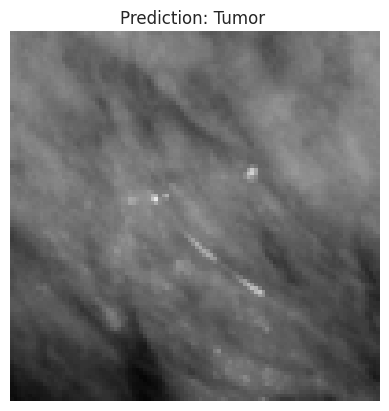

 Predicted Label: Tumor


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


model = tf.keras.models.load_model("efficientnetb0_brain_tumor_model.h5")


image_path = "/content/tumor_images/tumor_1111.png"


img = Image.open(image_path).convert('RGB')
img = img.resize((100, 100))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)


prediction = model.predict(img_array)




confidence = prediction[0][0]
label = "Non Tumor" if confidence >= 0.5 else "Tumor"


plt.imshow(img)
plt.title(f"Prediction: {label} ")
plt.axis('off')
plt.show()

print(f" Predicted Label: {label}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


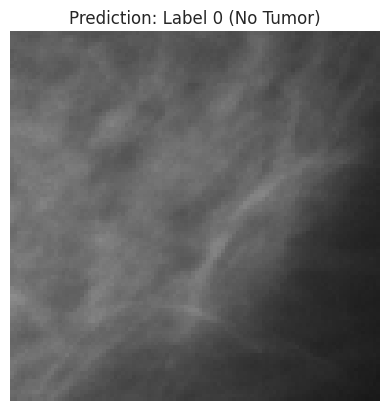

'Label 0 (No Tumor)'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def parse_tfrecord_fn(serialized_example):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    features = tf.io.parse_single_example(serialized_example, feature_description)

    label = features['label_normal']
    image = tf.io.decode_raw(features['image'], tf.uint8)

    image = tf.reshape(image, [299, 299, 1])
    image = tf.image.resize(image, [100, 100])
    image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0

    return image, label

# Load dataset from TFRecords
tfrecord_path = '/content/ddsm_dataset/training10_3/training10_3.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)

# Optimize dataset pipeline
parsed_dataset = (dataset
    .map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)


def classify_tfrecord_image(model, dataset):
    for image, label in dataset.take(1):
        image_array = image.numpy()


        prediction = model.predict(image_array)
        predicted_label = "Label 1 (Tumor)" if prediction >= 0.5 else "Label 0 (No Tumor)"


        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"Prediction: {predicted_label}")
        plt.axis("off")
        plt.show()

        return predicted_label


classify_tfrecord_image(model, parsed_dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


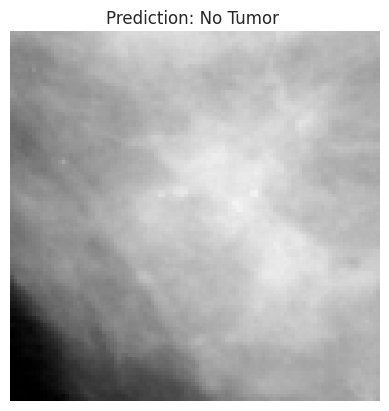

Predicted Label: No Tumor
Confidence Score: 0.0001


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


model = tf.keras.models.load_model("efficientnetb0_brain_tumor_model.h5")


image_path = "/content/random.jpg"


img = Image.open(image_path).convert('RGB')
img = img.resize((100, 100))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)


prediction = model.predict(img_array)
confidence = prediction[0][0]
label = "Tumor" if confidence >= 0.5 else "No Tumor"


plt.imshow(img)
plt.title(f"Prediction: {label} ")
plt.axis("off")
plt.show()


print(f"Predicted Label: {label}")
print(f"Confidence Score: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


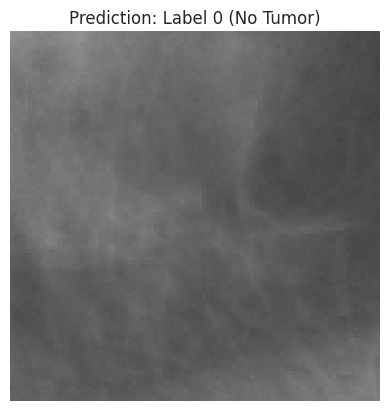

'Label 0 (No Tumor)'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def parse_tfrecord_fn(serialized_example):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    features = tf.io.parse_single_example(serialized_example, feature_description)

    label = features['label_normal']
    image = tf.io.decode_raw(features['image'], tf.uint8)

    image = tf.reshape(image, [299, 299, 1])  #
    image = tf.image.resize(image, [100, 100])  #
    image = tf.image.grayscale_to_rgb(image)  #
    image = image / 255.0  #

    return image, label  #


tfrecord_path = '/content/ddsm_dataset/training10_0/training10_0.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)


parsed_dataset = (dataset
    .map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)


def classify_tfrecord_image(model, dataset):
    for image, label in dataset.take(1):
        image_array = image.numpy()


        prediction = model.predict(image_array)
        predicted_label = "Label 1 (Tumor)" if prediction >= 0.5 else "Label 0 (No Tumor)"


        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"Prediction: {predicted_label}")
        plt.axis("off")
        plt.show()

        return predicted_label

# Classify a random image from the TFRecord dataset
classify_tfrecord_image(model, parsed_dataset)


Random Image Index: 5121
Label: 1 (Tumor)


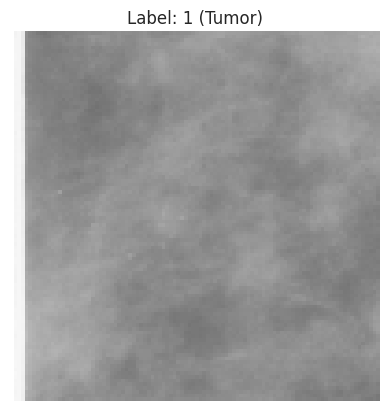

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# TFRecord parsing function
def parse_tfrecord_fn(serialized_example):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    features = tf.io.parse_single_example(serialized_example, feature_description)

    label = features['label_normal']
    image = tf.io.decode_raw(features['image'], tf.uint8)

    image = tf.reshape(image, [299, 299, 1])
    image = tf.image.resize(image, [100, 100])
    image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0

    return image, label


tfrecord_path = '/content/ddsm_dataset/training10_0/training10_0.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)
parsed_dataset = dataset.map(parse_tfrecord_fn)


dataset_list = list(parsed_dataset)


random_index = random.randint(0, len(dataset_list) - 1)
random_image, random_label = dataset_list[random_index]


label_value = random_label.numpy()
label_text = "Tumor" if label_value == 1 else "Non-Tumor"


print(f"Random Image Index: {random_index}")
print(f"Label: {label_value} ({label_text})")


plt.imshow(random_image.numpy().squeeze(), cmap='gray')
plt.title(f"Label: {label_value} ({label_text})")
plt.axis("off")
plt.show()


 Tumor Image Index: 519
Label: 1 (Tumor)


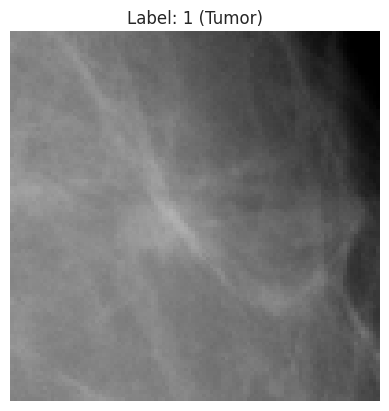

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random


def parse_tfrecord_fn(serialized_example):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    features = tf.io.parse_single_example(serialized_example, feature_description)

    label = features['label_normal']
    image = tf.io.decode_raw(features['image'], tf.uint8)

    image = tf.reshape(image, [299, 299, 1])
    image = tf.image.resize(image, [100, 100])
    image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0

    return image, label

tfrecord_path = '/content/ddsm_dataset/training10_0/training10_0.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)
parsed_dataset = dataset.map(parse_tfrecord_fn)

dataset_list = list(parsed_dataset)

tumor_images = [(img, lbl) for img, lbl in dataset_list if lbl.numpy() == 1]

if tumor_images:

    random_index = random.randint(0, len(tumor_images) - 1)
    random_image, random_label = tumor_images[random_index]


    print(f" Tumor Image Index: {random_index}")
    print(f"Label: {random_label.numpy()} (Tumor)")


    plt.imshow(random_image.numpy().squeeze(), cmap='gray')
    plt.title("Label: 1 (Tumor)")
    plt.axis("off")
    plt.show()
else:
    print("No tumor images found in the dataset.")


In [ ]:

ann_model=Sequential()
ann_model.add(Dense(8, input_dim=128, kernel_initializer = 'uniform', activation = 'relu'))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(16, kernel_initializer = 'HeUniform', activation = 'relu'))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(64, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(16, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(1,activation='sigmoid'))
ann_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 8)                   │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,457 (25.22 KB)

 Trainable params: 6,457 (25.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
names = [

        'SVM',

         ]
classifiers = [

    SVC(),



        ]
zipped_clf = zip(names,classifiers)



In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)

    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)

    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)


    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)


    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),2)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),2)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),2)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),2)



    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("Accuracy core : {}%".format(train_accuracy))
    cm=confusion_matrix(y_train,y_pred_train)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(val_accuracy))
    cm=confusion_matrix(y_val,y_pred_val)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

    print('------------------------ Test Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Kappa Score : {} ".format(test_kappa))
    print("Recall score: {}".format(test_recall))
    print("Precision score : {}".format(test_precision))
    cm=confusion_matrix(y_test,y_pred_test)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])


    print("-"*80)
    print()

In [ ]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('Classifier', c)])
        print("------------------------------Fitting {} on input_data-------------------------------- ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2021, shuffle=True, stratify=y_train)

In [ ]:
base_model= EfficientNetB0(input_shape=(100,100,3), weights='imagenet', include_top=False)
x = base_model.output
# x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
# x = Dense(16,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(128, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
val_features=model_feat.predict(x_val)
test_features=model_feat.predict(x_test)

1118/1118 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """

    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 92.35%
Confusion matrix, without normalization
[[30990   111]
 [ 2625  2040]]


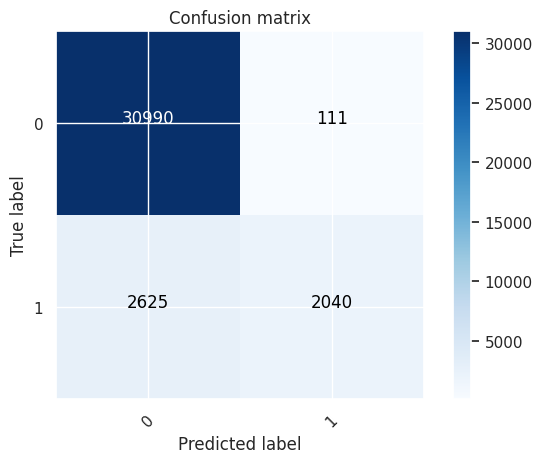

------------------------ Validation Set Metrics------------------------

Accuracy score : 90.33%
Confusion matrix, without normalization
[[7719   57]
 [ 808  358]]


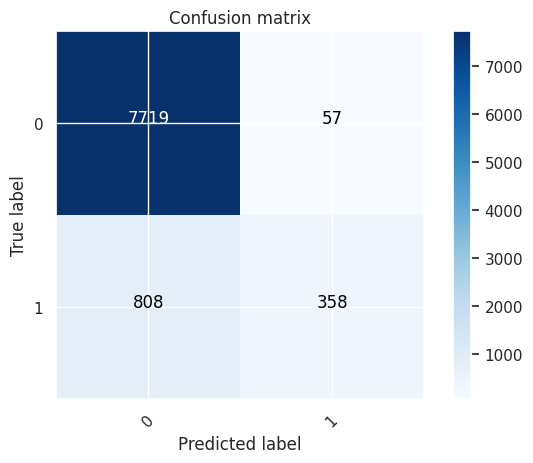

------------------------ Test Set Metrics------------------------

Accuracy score : 90.45%
F1_score : 0.88
Kappa Score : 0.42 
Recall score: 0.9
Precision score : 0.9
Confusion matrix, without normalization
[[9652   67]
 [1000  458]]


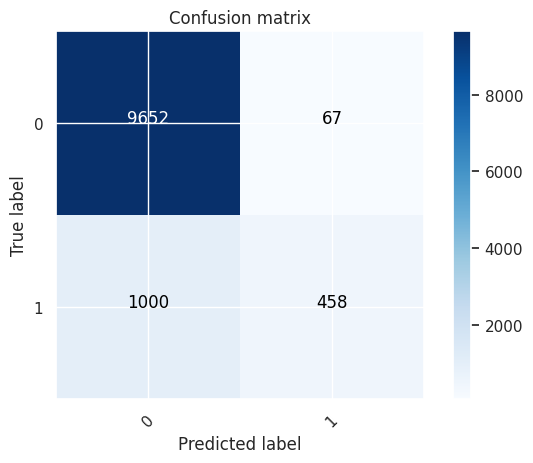

--------------------------------------------------------------------------------



In [ ]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)